# EDA


In [149]:
# Import the required libraries
import pandas as pd
import numpy as np
import scipy.stats as scs
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns

import us # cool package for easily working with US and state metadata: https://github.com/unitedstates/python-us

%matplotlib inline

In [208]:
usa_geo_regions_dict = {	'Alaska': 'West',
							'Alabama': 'Southeast',
							'Arizona': 'Southwest',
							'Arkansas': 'Southeast',
							'California': 'West',
							'Colorado': 'West',
							'Connecticut': 'Northeast',
							'District of Columbia': 'Northeast',
							'Delaware': 'Northeast',
							'Florida': 'Southeast',
							'Georgia': 'Southeast',
							'Hawaii': 'Southeast',
							'Iowa': 'Midwest',
							'Idaho': 'West',
							'Illinois': 'Midwest',
							'Indiana': 'Midwest',
							'Kansas': 'Midwest',
							'Kentucky': 'Southeast',
							'Louisiana': 'Southeast',
							'Massachusetts': 'Northeast',
							'Maryland': 'Northeast',
							'Maine': 'Northeast',
							'Michigan': 'Midwest',
							'Minnesota': 'Midwest',
							'Missouri': 'Midwest',
							'Mississippi': 'Southeast',
							'Montana': 'West',
							'North Carolina': 'Southeast',
							'North Dakota': 'Midwest',
							'Nebraska': 'Midwest',
							'New Hampshire': 'Northeast',
							'New Jersey': 'Northeast',
							'New Mexico': 'Southwest',
							'Nevada': 'West',
							'New York': 'Northeast',
							'Ohio': 'Midwest',
							'Oklahoma': 'Southwest',
							'Oregon': 'West',
							'Pennsylvania': 'Northeast',
							'Rhode Island': 'Northeast',
							'South Carolina': 'Southeast',
							'South Dakota': 'Midwest',
							'Tennessee': 'Southeast',
							'Texas': 'Southwest',
							'Utah': 'West',
							'Virginia': 'Southeast',
							'Vermont': 'Northeast',
							'Washington': 'West',
							'Wisconsin': 'Midwest',
							'West Virginia': 'Southeast',
							'Wyoming': 'West',
                            'USA': 'General USA'
							}

#  Functions
def get_pretty_percent(x, y):
    ''' Get formatted percent '''
    percentage = round(x/y, 3)
    return str(percentage) + '% '


def get_loc_state(location):
    '''
    Apply a simple hueristic to extract out the US state name from the user location. 
    Will also detect\extract the term 'USA'
    '''
    if 'USA' in location.upper():
        return 'USA'
    else:
        chunks = location.split(',')
        last_element = chunks[-1]
        return last_element.replace('.', '').replace('(', '').replace(')', '').replace('/', ' ').replace('|', ' ').replace('&', ' ').strip().upper()

def get_loc_state_vetted(loc_state):
    '''
    Return the vetted US state name or 'USA' or 'NOT VETTED'
    '''
    if loc_state == 'USA':
        return loc_state
    else:
        # Uses the us package for easily working with US and state metadata
        lookup_result = us.states.lookup(loc_state)
        if lookup_result is None:
            vetted_state = 'NOT VETTED'
        else:
            vetted_state = lookup_result.name
        return vetted_state

def get_us_geographic_region_for_state(loc_state):
    region = usa_geo_regions_dict[loc_state]
    if region is None:
        region = 'Unknown'
    return region

In [151]:
combined_tweets = pd.read_csv('../data/all_tweets_combined.csv')
combined_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38392 entries, 0 to 38391
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0        38392 non-null  int64 
 1   content           38392 non-null  object
 2   user_loc          38392 non-null  object
 3   user_screen_name  38392 non-null  object
 4   retweet_count     38392 non-null  int64 
 5   fav_count         38392 non-null  int64 
 6   created_at        38392 non-null  object
 7   char_count        38392 non-null  int64 
 8   sentiment_method  38392 non-null  object
 9   sentiment         38392 non-null  object
dtypes: int64(4), object(6)
memory usage: 2.9+ MB


In [152]:
combined_tweets.head()

,Unnamed: 0,content,user_loc,user_screen_name,retweet_count,fav_count,created_at,char_count,sentiment_method,sentiment
0,0,“Instructional Considerations for the 2020-21 ...,"Illinois, USA",Erik_Youngman,0,2,2020-08-02 00:10:26,276,tools,neutral
1,1,With all the uncertainty of what September wil...,"Lyndhurst, NJ",Renee_LoBue,0,0,2020-08-01 23:57:31,264,tools,positive
2,2,Check this out on Wakelet - Digital learning a...,"Cary, NC",SupriyaVasu,0,0,2020-08-01 23:20:38,133,tools,neutral
3,3,Happy Friendship Day!\n#rdnums #nagaland #kohi...,"Kohima, India",rdnums,2,1,2020-08-01 23:17:09,264,tools,positive
4,4,Beat the summer heat with over 400 cool games ...,"Providence, RI",ABCyaGames,0,2,2020-08-01 23:00:00,146,tools,positive


In [153]:

combined_tweets['loc_state'] = combined_tweets.apply(lambda row: get_loc_state(row['user_loc']), axis=1)
combined_tweets['loc_state_vetted'] = combined_tweets.apply(lambda row: get_loc_state_vetted(row['loc_state']), axis=1)
display(combined_tweets.head())

loc_state_series = pd.Series(combined_tweets['loc_state'].unique())
loc_state_series.to_csv('../data/unique_loc_states.csv')

loc_state_betted_series = pd.Series(combined_tweets['loc_state_vetted'].unique())
loc_state_betted_series.to_csv('../data/unique_VETTED_loc_states.csv')

,Unnamed: 0,content,user_loc,user_screen_name,retweet_count,fav_count,created_at,char_count,sentiment_method,sentiment,loc_state,loc_state_vetted
0,0,“Instructional Considerations for the 2020-21 ...,"Illinois, USA",Erik_Youngman,0,2,2020-08-02 00:10:26,276,tools,neutral,USA,USA
1,1,With all the uncertainty of what September wil...,"Lyndhurst, NJ",Renee_LoBue,0,0,2020-08-01 23:57:31,264,tools,positive,NJ,New Jersey
2,2,Check this out on Wakelet - Digital learning a...,"Cary, NC",SupriyaVasu,0,0,2020-08-01 23:20:38,133,tools,neutral,NC,North Carolina
3,3,Happy Friendship Day!\n#rdnums #nagaland #kohi...,"Kohima, India",rdnums,2,1,2020-08-01 23:17:09,264,tools,positive,INDIA,NOT VETTED
4,4,Beat the summer heat with over 400 cool games ...,"Providence, RI",ABCyaGames,0,2,2020-08-01 23:00:00,146,tools,positive,RI,Rhode Island


In [154]:
vetted_usa_tweets = combined_tweets[combined_tweets['loc_state_vetted'] != 'NOT VETTED']
vetted_usa_tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30599 entries, 0 to 38391
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0        30599 non-null  int64 
 1   content           30599 non-null  object
 2   user_loc          30599 non-null  object
 3   user_screen_name  30599 non-null  object
 4   retweet_count     30599 non-null  int64 
 5   fav_count         30599 non-null  int64 
 6   created_at        30599 non-null  object
 7   char_count        30599 non-null  int64 
 8   sentiment_method  30599 non-null  object
 9   sentiment         30599 non-null  object
 10  loc_state         30599 non-null  object
 11  loc_state_vetted  30599 non-null  object
dtypes: int64(4), object(8)
memory usage: 3.0+ MB


In [209]:
vetted_usa_tweets['region'] = vetted_usa_tweets.apply(lambda row: get_us_geographic_region_for_state(row['loc_state_vetted']), axis=1)
vetted_usa_tweets.head()

,Unnamed: 0,content,user_loc,user_screen_name,retweet_count,fav_count,created_at,char_count,sentiment_method,sentiment,loc_state,loc_state_vetted,created_at_datetime,region
0,0,“Instructional Considerations for the 2020-21 ...,"Illinois, USA",Erik_Youngman,0,2,2020-08-02 00:10:26,276,tools,neutral,USA,USA,2020-08-02 00:10:26,General USA
1,1,With all the uncertainty of what September wil...,"Lyndhurst, NJ",Renee_LoBue,0,0,2020-08-01 23:57:31,264,tools,positive,NJ,New Jersey,2020-08-01 23:57:31,Northeast
2,2,Check this out on Wakelet - Digital learning a...,"Cary, NC",SupriyaVasu,0,0,2020-08-01 23:20:38,133,tools,neutral,NC,North Carolina,2020-08-01 23:20:38,Southeast
4,4,Beat the summer heat with over 400 cool games ...,"Providence, RI",ABCyaGames,0,2,2020-08-01 23:00:00,146,tools,positive,RI,Rhode Island,2020-08-01 23:00:00,Northeast
5,5,Thanks Science for kids for the follow! Please...,"Boxford, MA",danieldowns,1,1,2020-08-01 20:38:08,229,tools,positive,MA,Massachusetts,2020-08-01 20:38:08,Northeast


In [156]:
# What are the value counts for the 3 different sentiments?
vetted_usa_tweets['sentiment'].value_counts()

positive    22618
neutral      4708
negative     3273
Name: sentiment, dtype: int64

In [157]:
# What are the value counts for the sentiment methods (tool or human?
vetted_usa_tweets['sentiment_method'].value_counts()

tools    30312
human      287
Name: sentiment_method, dtype: int64

In [163]:
# How many/what percentage Positive/Negative/Neutral?
by_sentiment = vetted_usa_tweets.groupby(['sentiment'])['content'].count()
by_sentiment.sort_values(ascending=False, inplace=True)

In [164]:
sns.set(style='white', context='talk')

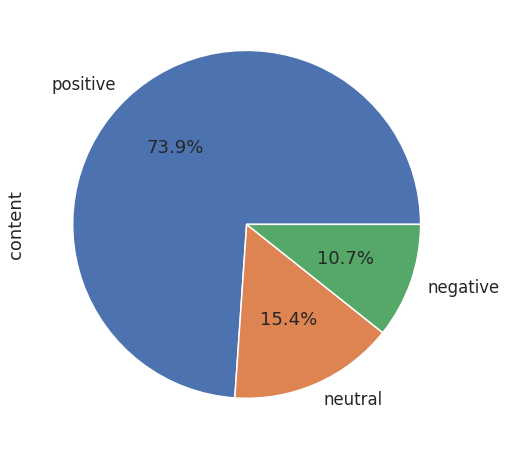

In [165]:
fig2, ax2 = plt.subplots(figsize=(8,8))
by_sentiment.plot.pie(autopct='%.1f%%');

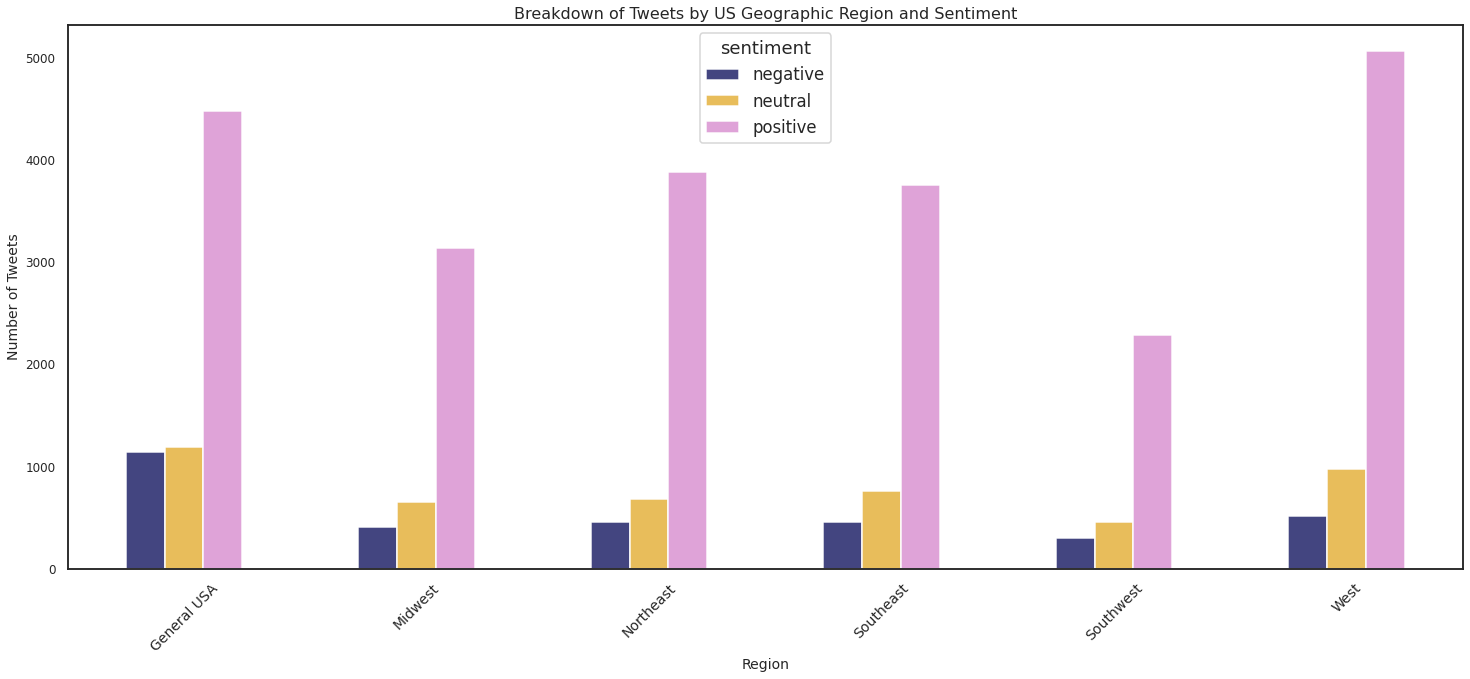

In [212]:
by_region_and_sentiment = vetted_usa_tweets.groupby(['region', 'sentiment'])['content'].count()

by_region_and_sentiment.unstack().plot.bar(fontsize=14, rot=45, alpha=0.95, figsize=(25,10), colormap='tab20b')
plt.title('Breakdown of Tweets by US Geographic Region and Sentiment', size='16')
plt.xlabel('Region',size=14)
plt.ylabel('Number of Tweets',size=14)
plt.yticks(size=12)
plt.show()

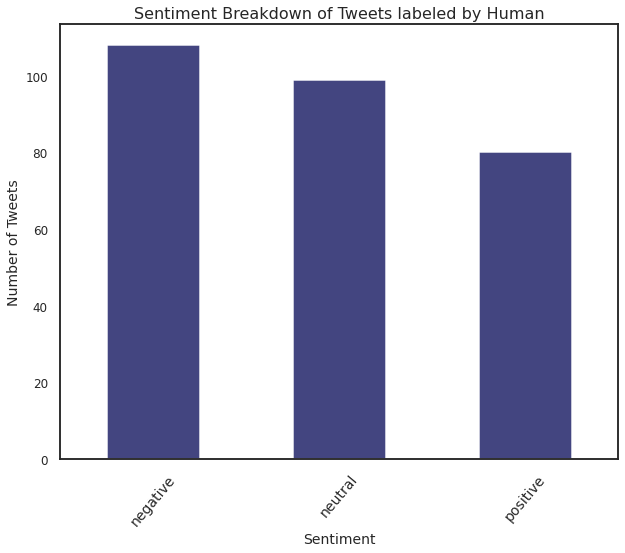

In [168]:
method_human = vetted_usa_tweets[vetted_usa_tweets['sentiment_method'] == 'human']

by_sentiment_method_human = method_human.groupby(['sentiment'])['content'].count()
by_sentiment_method_human.sort_values(ascending=False, inplace=True)

by_sentiment_method_human.plot.bar(fontsize=14, rot=50, alpha=0.95, figsize=(10,8), colormap='tab20b')
#plt.grid(color = 'black', alpha = 0.1, linestyle = '-', linewidth = 1)
plt.title('Sentiment Breakdown of Tweets labeled by Human', size='16')
plt.xlabel('Sentiment',size=14)
plt.ylabel('Number of Tweets',size=14)
plt.yticks(size=12)
plt.show()

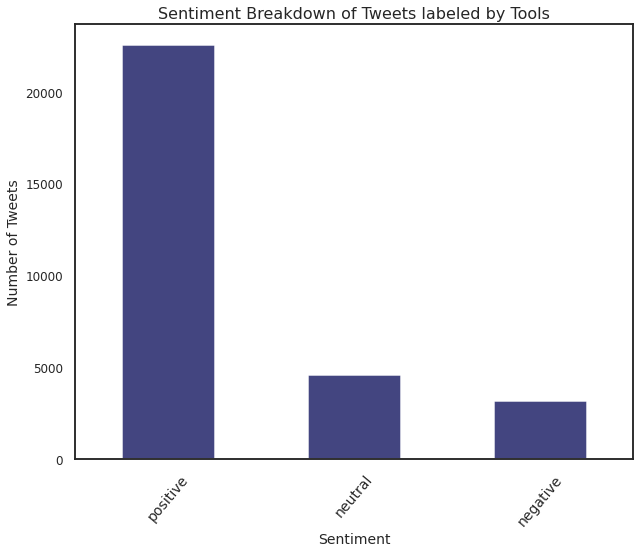

In [172]:
method_tools = vetted_usa_tweets[vetted_usa_tweets['sentiment_method'] == 'tools']
by_sentiment_method_tools = method_tools.groupby(['sentiment'])['content'].count()
by_sentiment_method_tools.sort_values(ascending=False, inplace=True)

by_sentiment_method_tools.plot.bar(fontsize=14, rot=50, alpha=0.95, figsize=(10,8), colormap='tab20b')
#plt.grid(color = 'black', alpha = 0.1, linestyle = '-', linewidth = 1)
plt.title('Sentiment Breakdown of Tweets labeled by Tools', size='16')
plt.xlabel('Sentiment',size=14)
plt.ylabel('Number of Tweets',size=14)
plt.yticks(size=12)
plt.show()

In [173]:
vetted_usa_tweets['created_at_datetime'] = pd.to_datetime(combined_tweets['created_at'])
vetted_usa_tweets.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 30599 entries, 0 to 38391
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Unnamed: 0           30599 non-null  int64         
 1   content              30599 non-null  object        
 2   user_loc             30599 non-null  object        
 3   user_screen_name     30599 non-null  object        
 4   retweet_count        30599 non-null  int64         
 5   fav_count            30599 non-null  int64         
 6   created_at           30599 non-null  object        
 7   char_count           30599 non-null  int64         
 8   sentiment_method     30599 non-null  object        
 9   sentiment            30599 non-null  object        
 10  loc_state            30599 non-null  object        
 11  loc_state_vetted     30599 non-null  object        
 12  created_at_datetime  30599 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(4),

Earliest Tweet datetime: 2020-07-23 23:57:06
Most recent Tweet datetime: 2021-01-13 18:05:23


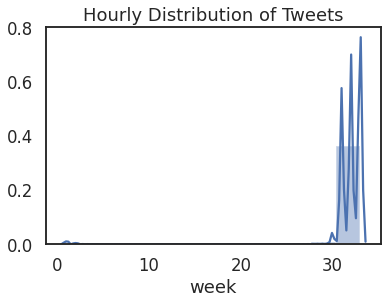

In [174]:

# Print the minimum datetime
print('Earliest Tweet datetime:', vetted_usa_tweets['created_at_datetime'].min())

# Print the maximum datetime
print('Most recent Tweet datetime:', vetted_usa_tweets['created_at_datetime'].max())


# Plot the histogram of hours
sns.distplot(vetted_usa_tweets['created_at_datetime'].dt.isocalendar().week , bins=12)
plt.title("Hourly Distribution of Tweets")
plt.show()

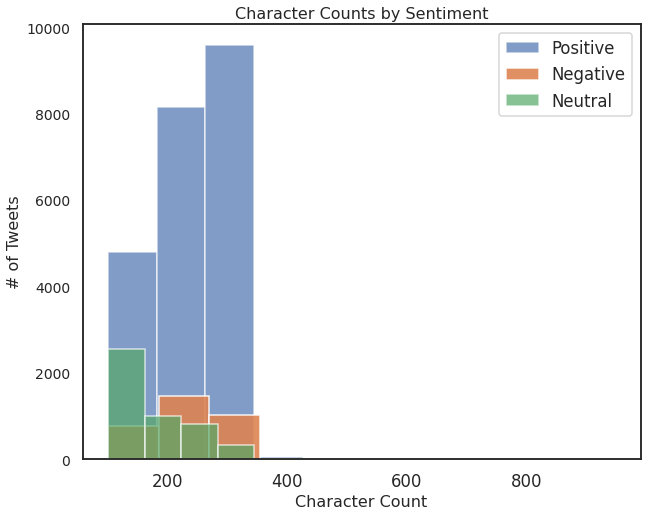

In [176]:
# Show the distribution of tweet character count for each of the sentiment classes
plfig = plt.figure(figsize = (10, 8))
plt.hist(vetted_usa_tweets[vetted_usa_tweets['sentiment'] == 'positive']['char_count'], alpha=0.7)
plt.hist(vetted_usa_tweets[vetted_usa_tweets['sentiment'] == 'negative']['char_count'], alpha=0.9)
plt.hist(vetted_usa_tweets[combined_tweets['sentiment'] == 'neutral']['char_count'], alpha=0.7)
plt.legend(('Positive', 'Negative', 'Neutral'))
plt.grid=False
plt.xlabel('Character Count', size=16)
plt.ylabel('# of Tweets', size=16)
plt.title('Character Counts by Sentiment', size=16)
plt.yticks(size=14)
plt.show()

In [177]:
vetted_usa_tweets.describe()

,Unnamed: 0,retweet_count,fav_count,char_count
count,30599.000000,30599.000000,30599.000000,30599.00000
mean,18911.705677,1.336416,5.153992,226.29916
std,11356.179817,10.713577,41.272296,63.70455
min,0.000000,0.000000,0.000000,100.00000
25%,8573.500000,0.000000,0.000000,173.00000
50%,18489.000000,0.000000,1.000000,239.00000
75%,29095.500000,1.000000,3.000000,278.00000
max,38391.000000,823.000000,3717.000000,949.00000


In [178]:
print('------------- ALL TWEETS...NO US VETTING ------------------')
print('------------- average retweet count by sentiment ------------------')
print('pos', combined_tweets[combined_tweets['sentiment'] == 'positive']['retweet_count'].mean())
print('neg', combined_tweets[combined_tweets['sentiment'] == 'negative']['retweet_count'].mean())
print('neutral', combined_tweets[combined_tweets['sentiment'] == 'neutral']['retweet_count'].mean())
print('------------- average fav count by sentiment  ------------------')
print('pos', combined_tweets[combined_tweets['sentiment'] == 'positive']['fav_count'].mean())
print('neg', combined_tweets[combined_tweets['sentiment'] == 'negative']['fav_count'].mean())
print('neutral', combined_tweets[combined_tweets['sentiment'] == 'neutral']['fav_count'].mean())
print('------------- average char count by sentiment  ------------------')
print('pos', combined_tweets[combined_tweets['sentiment'] == 'positive']['char_count'].mean())
print('neg', combined_tweets[combined_tweets['sentiment'] == 'negative']['char_count'].mean())
print('neutral', combined_tweets[combined_tweets['sentiment'] == 'neutral']['char_count'].mean())
print('------------- MEDIAN retweet count by sentiment ------------------')
print('pos', combined_tweets[combined_tweets['sentiment'] == 'positive']['retweet_count'].median())
print('neg', combined_tweets[combined_tweets['sentiment'] == 'negative']['retweet_count'].median())
print('neutral', combined_tweets[combined_tweets['sentiment'] == 'neutral']['retweet_count'].median())
print('------------- MEDIAN fav count by sentiment  ------------------')
print('pos', combined_tweets[combined_tweets['sentiment'] == 'positive']['fav_count'].median())
print('neg', combined_tweets[combined_tweets['sentiment'] == 'negative']['fav_count'].median())
print('neutral', combined_tweets[combined_tweets['sentiment'] == 'neutral']['fav_count'].median())
print('------------- MEDIAN char count by sentiment  ------------------')
print('pos', combined_tweets[combined_tweets['sentiment'] == 'positive']['char_count'].median())
print('neg', combined_tweets[combined_tweets['sentiment'] == 'negative']['char_count'].median())
print('neutral', combined_tweets[combined_tweets['sentiment'] == 'neutral']['char_count'].median())

------------- ALL TWEETS...NO US VETTING ------------------
------------- average retweet count by sentiment ------------------
pos 1.437807424183446
neg 1.7815188006881297
neutral 1.3157981530343008
------------- average fav count by sentiment  ------------------
pos 5.513924767330762
neg 5.852543622511674
neutral 4.0735488126649075
------------- average char count by sentiment  ------------------
pos 238.0872642344032
neg 231.93880560334233
neutral 180.4538258575198
------------- MEDIAN retweet count by sentiment ------------------
pos 0.0
neg 0.0
neutral 0.0
------------- MEDIAN fav count by sentiment  ------------------
pos 1.0
neg 1.0
neutral 0.0
------------- MEDIAN char count by sentiment  ------------------
pos 253.0
neg 244.0
neutral 160.0


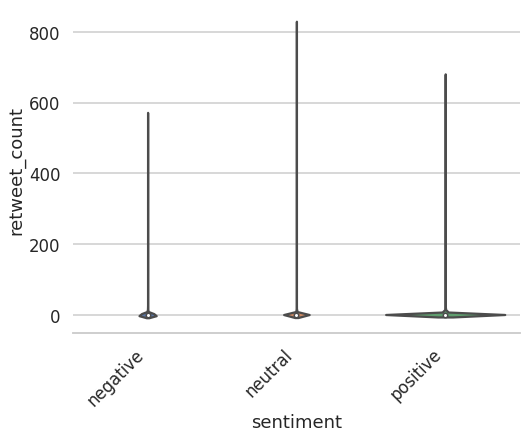

In [88]:
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(8, 6))
ax = sns.violinplot(data=combined_tweets, x='sentiment', y='retweet_count', order=sorted(combined_tweets.sentiment.unique()), scale='count',  bw=0.25, fliersize=20)
_ = plt.xticks(rotation=45, ha='right')
sns.despine(left=True)